In [ ]:
!pip install yfinance mplfinance pandas --quiet

In [ ]:
pip install --upgrade yfinance==0.2.59

In [7]:
# Import Libraries
import yfinance as yf
import pandas as pd
import mplfinance as mpf

In [58]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Download Historical OHLCV Data
company= "VEDL.NS"
Vedanta_data = yf.download(company,start='2024-04-01', end='2025-04-30') #Download Vedanta Stock data (2 Year)
print(Vedanta_data.head())
print(Vedanta_data.tail())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         VEDL.NS     VEDL.NS     VEDL.NS     VEDL.NS   VEDL.NS
Date                                                                
2024-04-01  261.427612  262.109597  248.560833  248.697224  17331916
2024-04-02  273.976135  274.567211  259.927259  260.927509  27928247
2024-04-03  271.702850  280.068545  270.793537  273.885225  19966252
2024-04-04  281.841705  284.160443  274.339870  278.295361  24723528
2024-04-05  290.025513  293.162627  278.204439  282.841915  22256365
Price            Close        High         Low        Open    Volume
Ticker         VEDL.NS     VEDL.NS     VEDL.NS     VEDL.NS   VEDL.NS
Date                                                                
2025-04-23  418.200012  419.700012  410.600006  416.000000   8692823
2025-04-24  420.250000  431.000000  416.500000  418.200012  13580010
2025-04-25  413.299988  425.799988  409.500000  422.850006  11205671
2025-04-28  416.100006  417.649994

In [9]:
#Extract to CSV for Later Use
Vedanta_data.to_csv('../data/vedanta.csv',index=True)

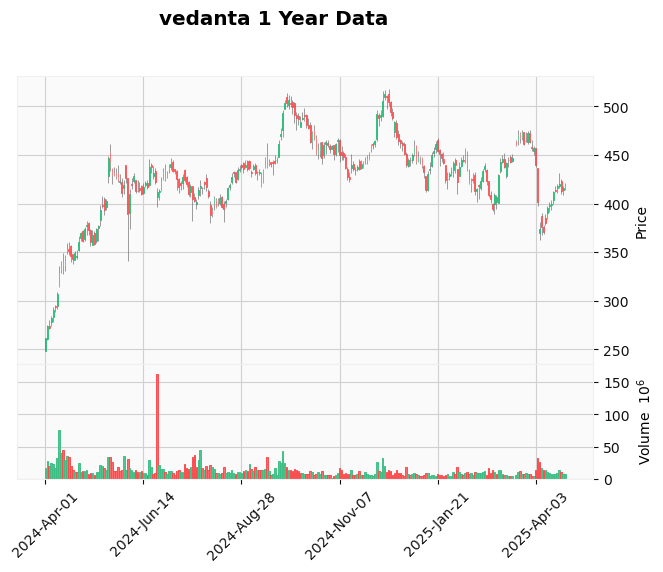

In [18]:
Vedanta_data.columns= Vedanta_data.columns.get_level_values(0) #flatten column names
mpf.plot(Vedanta_data[:], type='candle', volume = True ,style='yahoo' , title= "vedanta 1 Year Data")

### CandleStick Pattern Functions

In [36]:
'''
Hammer:
✔️ Condition 1: Body is < 30% of the full candle → small
✔️ Condition 2: Lower shadow is more than 2× body → strong rejection of lower prices
✔️ Condition 3: Upper shadow is smaller than body → small wick at the top
'''
def detect_hammer(data):
    body = abs(data['Close'] - data['Open'])
    candle_range = data['High'] - data['Low']
    lower_shadow = data[['Open','Close']].min(axis=1) - data['Low']
    upper_shadow = data['High'] - data[['Open','Close']].max(axis=1)
    
    return (body < 0.3* candle_range) & (lower_shadow > 2 *body) & (upper_shadow < body)

In [50]:
'''
Doji:
The opening and closing prices are nearly equal
The candle shows indecision between buyers and sellers
It usually has wicks/shadows on both ends, but the body is very small
'''

def detect_doji(data):
    body = abs(data['Close'] - data['Open'])
    candle_range = data['High'] - data['Low']
    return body <= 0.02 *candle_range

In [45]:
'''
Inverted Hammer (Bullish Reversal):
    Opposite of Hammer, long upper shadow
    After a downtrend, may suggest a reversal
    
    ✔️ Condition 1: Body is < 30% of the full candle → small
    ✔️ Condition 2: Upper shadow is more than 2× body → strong rejection of lower prices
    ✔️ Condition 3: Lower shadow is smaller than body → small wick at the top

'''

def detect_inverted_hammer(data):
    body = abs(data['Close']- data['Open'])
    candle_range = data['High'] - data['Low']
    lower_shadow = data[['Open','Close']].min(axis=1) - data['Low']
    upper_shadow = data['High'] - data[['Open','Close']].max(axis=1)
    
    return (body < 0.3 * candle_range) & (upper_shadow > 2*body) & (lower_shadow < body)
    

In [46]:
'''
Shooting Star (Bearish Reversal):
    Same shape as Inverted Hammer but appears after an uptrend
    Signals bearish reversal
'''
def detect_shooting_star(data):
    body = abs(data['Close']- data['Open'])
    candle_range = data['High'] - data['Low']
    lower_shadow = data[['Open','Close']].min(axis=1) - data['Low']
    upper_shadow = data['High'] - data[['Open','Close']].max(axis=1)
    
    return (body < 0.3 * candle_range) & (upper_shadow > 2*body) & (lower_shadow < body)

In [40]:
'''
Bullish Engulfing:
    Green candle completely engulfs previous red candle
    Signals strong bullish reversal
'''

def detect_bullish_engulfing(data):
    prev_close = data['Close'].shift(1)
    prev_open = data['Open'].shift(1)
    
    return (
        (prev_close < prev_open) & # previous Candle is red
        (data['Close'] > data['Open']) & # current Candle is green
        (data['Open'] < prev_close) & # current opens lower than prev close
        (data['Close']> prev_open) # current close higher than prev open
    )

In [41]:
'''
Bearish Engulfing:
    Red candle completely engulfs previous green candle
    Signals strong bearish reversal
'''

def detect_bearish_engulfing(data):
    prev_close = data['Close'].shift(1)
    prev_open = data['Open'].shift(1)
    
    return (
        (prev_close > prev_open) & # previous Candle is green
        (data['Close'] < data['Open']) & # current Candle is red
        (data['Open'] > prev_close) & # opens above previous close
        (data['Close'] < prev_open) # closes below previous open
    )

In [42]:
'''
Morning Star (3- Candle Bullish Reversal): Perviously DownTrend
    Day 1 - Red Candle
    Day 2 - Small Body : Doji or Sppining Top 
    Day 3 - Big Green Candle  D3 Close ~ >= D1 Open
'''
def detect_morning_star(data):
    c1 = data['Close'].shift(2)
    o1 = data['Open'].shift(2)
    c2 = data['Close'].shift(1)
    o2 = data['Open'].shift(1)
    c3 = data['Close']
    o3 = data['Open']

    return (
        (c1 < o1) &  # red candle
        (abs(c2 - o2) < 0.1 * (data['High'] - data['Low']).shift(1)) &  # small body
        (c3 > o3) & (c3 > ((c1 + o1) / 2))  # big green candle &  closing > midpoint of first candle
    )

In [43]:
'''
Evening Star (3-candle Bearish Reversal): Perviously UpTrend
    Day 1 - Green Candle
    Day 2 - Small Body : Doji or Sppining Top 
    Day 3 - Big Red Candle  D3 Close ~ <= D1 Open
'''
def detect_evening_star(data):
    c1 = data['Close'].shift(2)
    o1 = data['Open'].shift(2)
    c2 = data['Close'].shift(1)
    o2 = data['Open'].shift(1)
    c3 = data['Close']
    o3 = data['Open']

    return (
        (c1 > o1) &  # Green Candle
        (abs(c2 - o2) < 0.1 * (data['High'] - data['Low']).shift(1)) &  # small body
        (c3 < o3) & (c3 < ((c1 + o1) / 2))  # red candle &  closing < midpoint of first candle
    )

### Apply All Pattern to our DataFrame

In [51]:
Vedanta_data['Doji'] = detect_doji(Vedanta_data)
Vedanta_data['Hammer'] = detect_hammer(Vedanta_data)
Vedanta_data['Inv_Hammer'] = detect_inverted_hammer(Vedanta_data)
Vedanta_data['Shooting_Star'] = detect_shooting_star(Vedanta_data)
Vedanta_data['Bull_Engulf'] = detect_bullish_engulfing(Vedanta_data)
Vedanta_data['Bear_Engulf'] = detect_bearish_engulfing(Vedanta_data)
Vedanta_data['Morning_Star'] = detect_morning_star(Vedanta_data)
Vedanta_data['Evening_Star'] = detect_evening_star(Vedanta_data)

In [59]:
Vedanta_data['Doji_marker'] = np.where(Vedanta_data['Doji'], Vedanta_data['Close'], np.nan)
Vedanta_data['Hammer_marker'] = np.where(Vedanta_data['Hammer'], Vedanta_data['Low'] * 0.98, np.nan)
Vedanta_data['Shooting_marker'] = np.where(Vedanta_data['Shooting_Star'], Vedanta_data['High'] * 1.02, np.nan)
Vedanta_data['Bull_marker'] = np.where(Vedanta_data['Bull_Engulf'], Vedanta_data['Close'], np.nan)
Vedanta_data['Bear_marker'] = np.where(Vedanta_data['Bear_Engulf'], Vedanta_data['Close'], np.nan)

In [60]:
Vedanta_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2024-04-01 to 2025-04-29
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close            266 non-null    float64
 1   High             266 non-null    float64
 2   Low              266 non-null    float64
 3   Open             266 non-null    float64
 4   Volume           266 non-null    int64  
 5   Doji             266 non-null    bool   
 6   Hammer           266 non-null    bool   
 7   Inv_Hammer       266 non-null    bool   
 8   Shooting_Star    266 non-null    bool   
 9   Bull_Engulf      266 non-null    bool   
 10  Bear_Engulf      266 non-null    bool   
 11  Morning_Star     266 non-null    bool   
 12  Evening_Star     266 non-null    bool   
 13  Doji_marker      5 non-null      float64
 14  Hammer_marker    15 non-null     float64
 15  Shooting_marker  7 non-null      float64
 16  Bull_marker      5 non-null      float64
 1

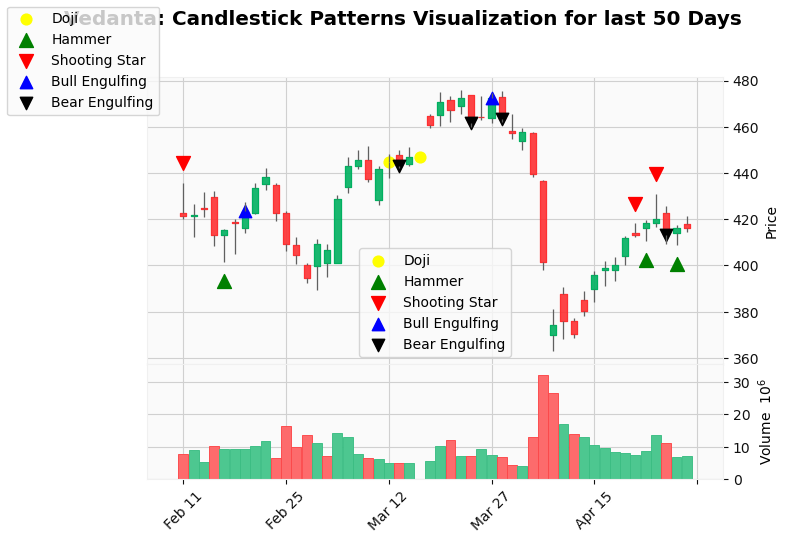

In [65]:
# Plotting with markers
apds = [] # empty list that will hold all the addplot() overlays (markers).

apds.append(mpf.make_addplot(Vedanta_data[-50:]['Doji_marker'], type='scatter', color='yellow', marker='o', markersize=60, label='Doji'))
apds.append(mpf.make_addplot(Vedanta_data[-50:]['Hammer_marker'], type='scatter', color='green', marker='^', markersize=100, label='Hammer'))
apds.append(mpf.make_addplot(Vedanta_data[-50:]['Shooting_marker'], type='scatter', color='red', marker='v', markersize=100, label='Shooting Star'))
apds.append(mpf.make_addplot(Vedanta_data[-50:]['Bull_marker'], type='scatter', color='blue', marker='^', markersize=80, label='Bull Engulfing'))
apds.append(mpf.make_addplot(Vedanta_data[-50:]['Bear_marker'], type='scatter', color='black', marker='v', markersize=80, label='Bear Engulfing'))

# Final candlestick plot
mpf.plot(Vedanta_data[-50:], type='candle', style='yahoo', volume=True,
         addplot=apds, title='Vedanta: Candlestick Patterns Visualization for last 50 Days',ylabel='Price',returnfig=True)[0].legend(loc='upper left')